In [1]:
import json

from matplotlib import pyplot as plt
import pdal
import rasterio
import rasterio.fill

In [17]:
IN_FILE_LAS = r'./datasets/Izu_proj.las'
OUT_FILE_CLD = r'./datasets/Izu_proj_pre_classified.las'
OUT_FILE_OBJ = r'./datasets/Izu_proj_normalized_obj.las'
OUT_FILE_RASTER = r'./datasets/Izu_dtm.tif'
OUT_FILE_CHM = r'./datasets/Izu_chm.tif'

CSFによる点群分類と分類済み点群データの出力

In [10]:
workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': IN_FILE_LAS
        },
        {
            'type': 'filters.csf',
            'resolution': 0.5,
            'rigidness': 3,
            'threshold': 1.0
        },
        {
            'type': 'writers.las',
            'filename': OUT_FILE_CLD,
        }
    ]
}
pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

22350278

点群データから地表点群を抽出し、DTMとして出力

In [11]:
workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': OUT_FILE_CLD
        },
        {
            'type': 'filters.expression',
            'expression': 'Classification == 2'
        },
        {
            'type': 'writers.gdal',
            'filename': OUT_FILE_RASTER,
            'resolution':0.5,
            'radius': 1.0,
            'window_size': 10,
            'output_type': 'min',
            'gdaldriver':'GTiff',
        }
    ]
}
pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

1436674

DTMの欠損値を処理する

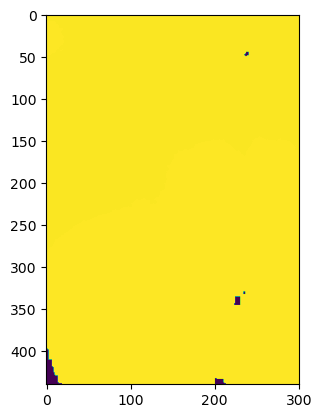

In [12]:
dst = rasterio.open(OUT_FILE_RASTER)
ary = dst.read(1)
plt.imshow(ary);

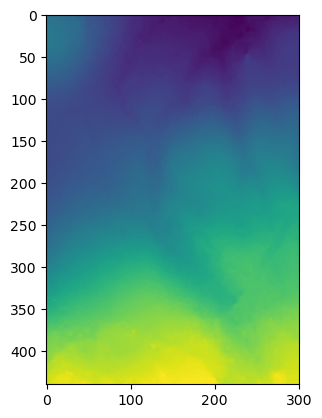

In [14]:
filled_ary = rasterio.fill.fillnodata(ary, dst.read_masks(1))
plt.imshow(filled_ary);

In [16]:
metadata = dst.meta
dst.close()

with rasterio.open(OUT_FILE_RASTER, mode='w', **metadata) as dst:
    dst.write(filled_ary, 1)

地上の点群データからDTMを差し引き、オブジェクト高の点群データを作成する。

In [18]:
workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': OUT_FILE_CLD
        },
        {
            'type': 'filters.expression',
            'expression': 'Classification == 1'
        },
        {
            'type': 'filters.hag_dem',
            'raster': OUT_FILE_RASTER
        },
        {
            'type': 'filters.assign',
            'value': [
                "Z = HeightAboveGround"
            ]
        },
        {
            'type': 'writers.las',
            'filename': OUT_FILE_OBJ
        },
        {
            'type': 'writers.gdal',
            'filename': OUT_FILE_CHM,
            'resolution':0.5,
            'window_size': 1,
            'output_type': 'max',
            'gdaldriver':'GTiff',
            'nodata': 0
        }
    ]
}

pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

20913604

CHMを確認する

In [19]:
dst_chm = rasterio.open(OUT_FILE_CHM)
chm = dst_chm.read(1)

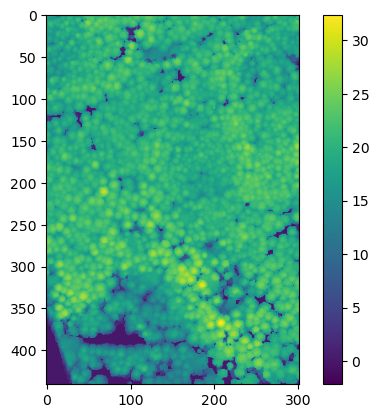

In [22]:
plt.imshow(chm)
plt.colorbar();